In [1]:
import yfinance as yf
import pandas as pd
import plotly.express as px
import matplotlib.pylab as plt
import numpy as np
import talib
import pickle
from talipp.indicators import EMA, SMA, Stoch, DPO
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from own_functions import *
from math import *
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

c:\Users\Atharv\anaconda3\envs\my_env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Atharv\anaconda3\envs\my_env\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Atharv\anaconda3\envs\my_env\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Fetch historical df from Yahoo Finance
symbol = "USDCAD=X"
ohlc_data = yf.download(symbol, start="2010-01-01", end=datetime.now(), progress=False)

df = ohlc_data[['Open', 'High', 'Low', 'Close']].reset_index()
df.columns = ['time', 'open', 'high', 'low', 'close']

# Indicators
df['WILLR_15'] = talib.WILLR(df['high'], df['low'], df['open'], timeperiod=15)
df['WILLR_23'] = talib.WILLR(df['high'], df['low'], df['open'], timeperiod=23)
df['WILLR_42'] = talib.WILLR(df['high'], df['low'], df['open'], timeperiod=42)
df['WILLR_145'] = talib.WILLR(df['high'], df['low'], df['open'], timeperiod=145)

# Buy & Sell Flags
df['b_flag'] = 0
df['s_flag'] = 0

df = df.dropna()
df = df.reset_index(drop=True)

# Label df: label_df(dfFrame, StopLoss, TakeProfit, Period, Symbol, Plot)
StopLoss = 1
TakeProfit = 2
BreakEvenRatio = StopLoss / (StopLoss + TakeProfit)
label_data(df, [StopLoss], [TakeProfit], 80, symbol, False)

df

Mean Candle: 0.007490880345158101


,time,open,high,low,close,WILLR_15,WILLR_23,WILLR_42,WILLR_145,b_flag,s_flag
0,2010-07-22,1.04780,1.05014,1.03544,1.03617,-49.410681,-39.717839,-43.734530,-40.259523,0,1
1,2010-07-23,1.03624,1.04230,1.03440,1.03580,-78.404803,-77.338107,-60.460254,-52.861677,0,1
2,2010-07-26,1.03730,1.03790,1.03020,1.03180,-75.746141,-75.746141,-56.586368,-51.706103,0,1
3,2010-07-27,1.03190,1.03870,1.02530,1.03520,-81.164331,-84.360125,-66.604813,-57.592878,0,1
4,2010-07-28,1.03190,1.03890,1.02970,1.03789,-79.999928,-84.360125,-66.604813,-57.592878,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3550,2024-03-08,1.34520,1.34765,1.34227,1.34520,-83.892679,-80.147634,-58.111537,-61.305664,0,0
3551,2024-03-11,1.34845,1.35089,1.34690,1.34845,-66.025729,-63.078281,-46.210439,-56.772257,0,0
3552,2024-03-12,1.34775,1.35243,1.34650,1.34775,-69.873975,-66.754738,-51.856716,-57.748678,0,0
3553,2024-03-13,1.34931,1.34981,1.34600,1.34931,-61.297341,-61.297341,-45.491598,-55.572517,0,0


In [3]:
target='b_flag'
#target='s_flag'

selected_signal='WILLR_15'

df_melted = df[['time',selected_signal]]
df_melted["Symbols"] = symbol

df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="time",
                             max_timeshift=20, min_timeshift=5)

X = extract_features(df_rolled.drop("Symbols", axis=1), 
                     column_id="id", column_sort="time", column_value=selected_signal, 
                     impute_function=impute, show_warnings=False)

X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "time"
X=X.dropna()

""" selected_signal='WILLR_23'


df_melted = df[['time',selected_signal]]
df_melted["Symbols"] = symbol

df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="time",
                             max_timeshift=20, min_timeshift=5)

X2 = extract_features(df_rolled.drop("Symbols", axis=1), 
                     column_id="id", column_sort="time", column_value=selected_signal, 
                     impute_function=impute, show_warnings=False)

X2 = X2.set_index(X2.index.map(lambda x: x[1]), drop=True)
X2.index.name = "time"
X2=X2.dropna() """

selected_signal='WILLR_42'


df_melted = df[['time',selected_signal]]
df_melted["Symbols"] = symbol

df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="time",
                             max_timeshift=20, min_timeshift=5)

X3 = extract_features(df_rolled.drop("Symbols", axis=1), 
                     column_id="id", column_sort="time", column_value=selected_signal, 
                     impute_function=impute, show_warnings=False)

X3 = X3.set_index(X3.index.map(lambda x: x[1]), drop=True)
X3.index.name = "time"
X3=X3.dropna()

""" selected_signal='WILLR_145'

df_melted = df[['time',selected_signal]]
df_melted["Symbols"] = symbol

df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="time",
                             max_timeshift=20, min_timeshift=5)

X4 = extract_features(df_rolled.drop("Symbols", axis=1), 
                     column_id="id", column_sort="time", column_value=selected_signal, 
                     impute_function=impute, show_warnings=False)

X4 = X4.set_index(X4.index.map(lambda x: x[1]), drop=True)
X4.index.name = "time"
X4=X4.dropna() """

df=df.set_index('time')
df = df[df.index.isin(X.index)]
X = select_features(X, df[target])
#X2 = select_features(X2, df[target])
X3 = select_features(X3, df[target])
#X4 = select_features(X4, df[target])
#df = pd.concat([X, X2, X3, X4, df], axis=1)
df = pd.concat([X, X3, df], axis=1)
#df.to_csv('Data/df_selected_features.csv', index=True)

#df=df.drop(columns=['time'])
df=df.drop(columns=['high','low','close','open'])
#df=df.dropna()
#df=df.reset_index(drop=True)

Feature Extraction: 100%|██████████| 30/30 [01:42<00:00,  3.42s/it]


In [4]:
def custom_time_series_split(df, n_splits, test_size=0.1):
    total_samples = len(df)
    test_samples = int(total_samples * test_size)  # Calculate number of samples for the test set
    print("Total Samples:", total_samples)
    print("Test Samples:", test_samples)

    # Calculate split indices
    split_indices = [total_samples - (n_splits - i) * test_samples for i in range(n_splits)]
    print("Split Indices:", split_indices)

    # First split with 50% data
    train_index_1 = df.index[:split_indices[0]]
    test_index_1 = df.index[split_indices[0]:]
    print("Fold 1 Train:", train_index_1, "Test:", test_index_1)
    yield train_index_1, test_index_1

    # Subsequent splits with desired pattern
    for i in range(1, n_splits):
        train_index = df.index[:split_indices[i]]
        if i == n_splits - 1:
            test_index = df.index[split_indices[i]:]  # Using all remaining indices for the last split
        else:
            test_index = df.index[split_indices[i]:len(df)]  # Include all remaining indices for the test set
        print("Fold", i+1, "Train:", train_index)
        print("Test:", test_index)

        yield train_index, test_index


# Define custom time series split with 5 splits
tscv = custom_time_series_split(df, n_splits=5) 

sum_fp = 0
sum_tp = 0
overall_trades = 0

for train_index, test_index in tscv:
    train_data = df.loc[train_index]
    test_data = df.loc[test_index]
    print("Train Data Shape:", train_data.shape)
    print("Test Data Shape:", test_data.shape)
    
    # Train data
    x_train = train_data.iloc[:, :-2].values  # Adjust column selection based on your DataFrame
    y_train = train_data[target].values   # Adjust column selection based on your DataFrame
    
    # Test data
    x_test = test_data.iloc[:, :-2].values    # Adjust column selection based on your DataFrame
    y_test = test_data[target].values      # Adjust column selection based on your DataFrame

    # Scale Data
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)

    # Hyperparameters
    n_estimators = 120
    class_weight = {0: 5, 1: 10}
    max_features = 'log2'
    random_state = 42

    # Initialize RandomForestClassifier
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        class_weight=class_weight,
        max_features=max_features,
        random_state=random_state
    )

    # Train Model
    rf_classifier.fit(x_train, y_train)

    # Predict
    #y_pred = rf_classifier.predict(x_test)

    train_pred = rf_classifier.predict(x_train)
    y_pred = rf_classifier.predict(x_test)

    print("Training Data Classification Report:")
    print(classification_report(y_train, train_pred))

    print("Test Data Classification Report:")
    print(classification_report(y_test, y_pred))
    # Evaluate
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    false_positives = confusion_matrix(y_test, y_pred)[0][1]
    true_positives = confusion_matrix(y_test, y_pred)[1][1]
    no_of_trades = false_positives + true_positives
    sum_fp += false_positives
    sum_tp += true_positives
    overall_trades += no_of_trades


    precision = precision_score(y_test, y_pred)
    print('WIN/LOSS-Diff:', round(100 * (precision - BreakEvenRatio), 2), '%')
    print('sum_fp:', sum_fp)
    print('sum_tp:', sum_tp)
    print('no_of_trades',no_of_trades)
    print('precision', precision)
    print('Ratio total', round(100 * (sum_tp / (sum_fp + sum_tp)), 2))
    print('BreakEvenRatio:', round(BreakEvenRatio, 2))
    print('____________________________________________________________________________________________________________________________')
print('overall_trades',overall_trades)

Total Samples: 3550
Test Samples: 355
Split Indices: [2130, 2485, 2840, 3195]
Fold 1 Train: DatetimeIndex(['2010-07-29', '2010-07-30', '2010-08-02', '2010-08-03',
               '2010-08-04', '2010-08-05', '2010-08-06', '2010-08-09',
               '2010-08-10', '2010-08-11',
               ...
               '2018-09-20', '2018-09-21', '2018-09-24', '2018-09-25',
               '2018-09-26', '2018-09-27', '2018-09-28', '2018-10-01',
               '2018-10-02', '2018-10-03'],
              dtype='datetime64[ns]', name='time', length=2130, freq=None) Test: DatetimeIndex(['2018-10-04', '2018-10-05', '2018-10-08', '2018-10-09',
               '2018-10-10', '2018-10-11', '2018-10-12', '2018-10-15',
               '2018-10-16', '2018-10-17',
               ...
               '2024-03-01', '2024-03-04', '2024-03-05', '2024-03-06',
               '2024-03-07', '2024-03-08', '2024-03-11', '2024-03-12',
               '2024-03-13', '2024-03-14'],
              dtype='datetime64[ns]', name='tim

Feature Importances:
                                              Feature  Importance
24  WILLR_42__change_quantiles__f_agg_"var"__isabs...    0.043686
13  WILLR_15__change_quantiles__f_agg_"var"__isabs...    0.042270
25  WILLR_42__change_quantiles__f_agg_"var"__isabs...    0.041785
30                                          WILLR_145    0.041502
27                                           WILLR_15    0.041240
6                    WILLR_15__autocorrelation__lag_4    0.039243
29                                           WILLR_42    0.039038
12          WILLR_15__approximate_entropy__m_2__r_0.9    0.037854
21                          WILLR_15__quantile__q_0.3    0.037801
28                                           WILLR_23    0.037505
16                   WILLR_15__autocorrelation__lag_5    0.037444
1   WILLR_15__change_quantiles__f_agg_"var"__isabs...    0.036992
2   WILLR_15__change_quantiles__f_agg_"var"__isabs...    0.036972
10  WILLR_15__change_quantiles__f_agg_"var"__isabs...  

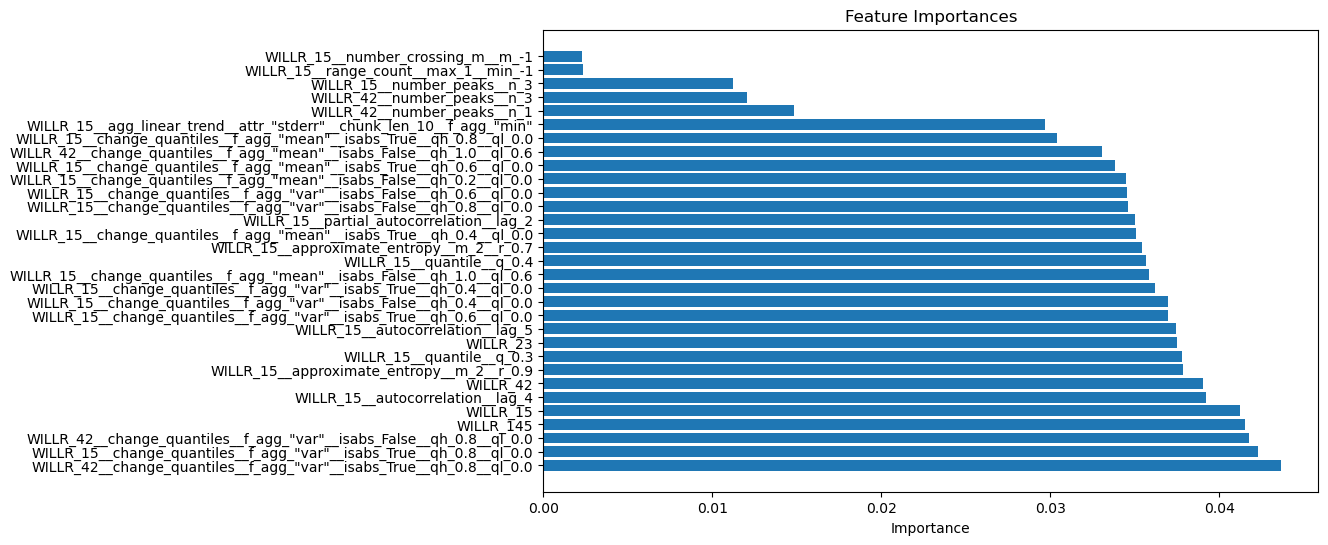

In [5]:
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importances
x_train_df = pd.DataFrame(x_train, columns=df.columns[:-2])

# Get feature names from the DataFrame
feature_names = x_train_df.columns.tolist()


feature_importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': feature_importances}
)

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or display the feature importance DataFrame
print("Feature Importances:")
print(feature_importance_df)

# Plotting the feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()


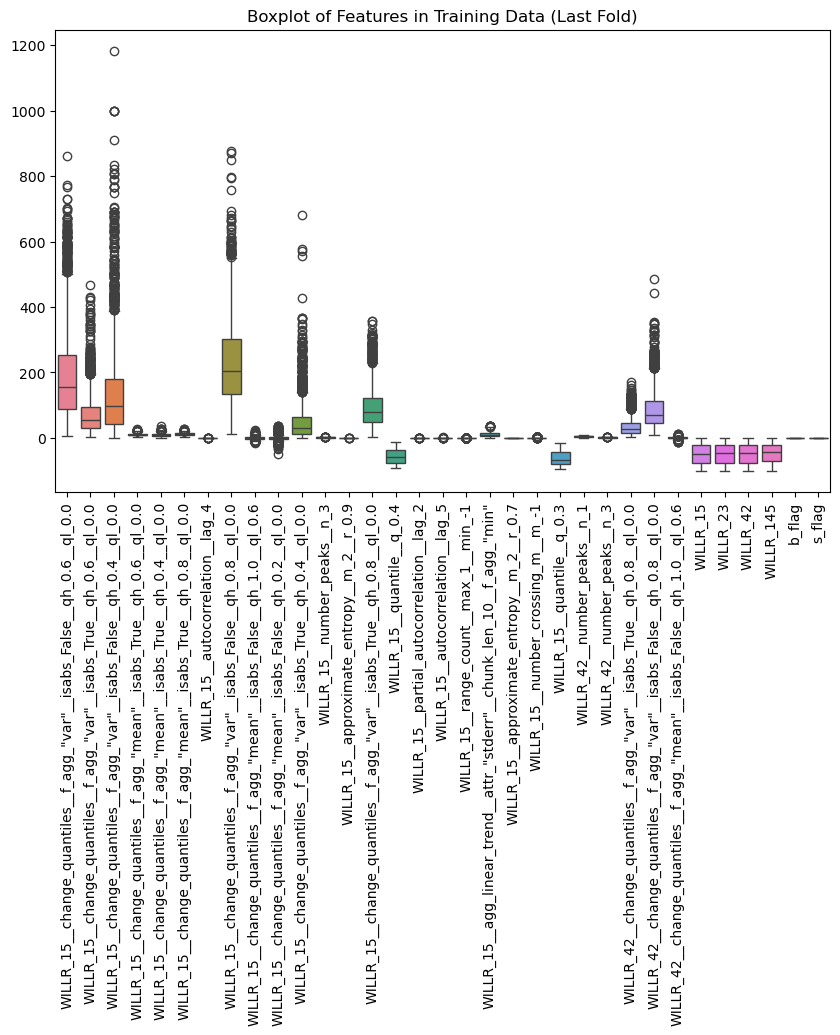

In [6]:
import seaborn as sns

# Analyze feature distributions in training data of last fold
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_data)
plt.title("Boxplot of Features in Training Data (Last Fold)")
plt.xticks(rotation=90)
plt.show()

In [7]:
# Evaluate model performance on training and test data of last fold
from sklearn.metrics import classification_report

train_pred = rf_classifier.predict(x_train)
test_pred = rf_classifier.predict(x_test)

print("Training Data Classification Report:")
print(classification_report(y_train, train_pred))

print("Test Data Classification Report:")
print(classification_report(y_test, test_pred))


Training Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2061
           1       1.00      1.00      1.00      1134

    accuracy                           1.00      3195
   macro avg       1.00      1.00      1.00      3195
weighted avg       1.00      1.00      1.00      3195

Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.94      0.81       252
           1       0.24      0.05      0.08       103

    accuracy                           0.68       355
   macro avg       0.47      0.49      0.44       355
weighted avg       0.57      0.68      0.60       355



In [8]:
import pandas as pd

def custom_time_series_split(df, n_splits, test_size=0.1):
    total_samples = len(df)
    test_samples = int(total_samples * test_size)  # Calculate number of samples for the test set
    print("Total Samples:", total_samples)
    print("Test Samples:", test_samples)

    # Calculate split indices
    split_indices = [total_samples - (n_splits - i) * test_samples for i in range(n_splits)]
    print("Split Indices:", split_indices)

    # First split with 50% data
    train_index_1 = df.index[:split_indices[0]]
    test_index_1 = df.index[split_indices[0]:]
    print("Fold 1 Train:", train_index_1, "Test:", test_index_1)
    yield train_index_1, test_index_1

    # Subsequent splits with desired pattern
    for i in range(1, n_splits):
        train_index = df.index[:split_indices[i]]
        if i == n_splits - 1:
            test_index = df.index[split_indices[i]:]  # Using all remaining indices for the last split
        else:
            test_index = df.index[split_indices[i]:len(df)]  # Include all remaining indices for the test set
        print("Fold", i+1, "Train:", train_index, "Test:", test_index)

        yield train_index, test_index

# Test the function
df_index = list(range(1, 11))
df = pd.DataFrame(index=df_index)
custom_splits = list(custom_time_series_split(df, n_splits=5))

# Verify the splits
desired_splits = [
    ([1, 2, 3, 4, 5], [6, 7, 8, 9, 10]),
    ([1, 2, 3, 4, 5, 6], [7, 8, 9, 10]),
    ([1, 2, 3, 4, 5, 6, 7], [8, 9, 10]),
    ([1, 2, 3, 4, 5, 6, 7, 8], [9, 10]),
    ([1, 2, 3, 4, 5, 6, 7, 8, 9], [10])
]

matches = all(train.tolist() == desired_splits[i][0] and test.tolist() == desired_splits[i][1] for i, (train, test) in enumerate(custom_splits))
print("Splits match the desired pattern:", matches)


Total Samples: 10
Test Samples: 1
Split Indices: [5, 6, 7, 8, 9]
Fold 1 Train: Index([1, 2, 3, 4, 5], dtype='int64') Test: Index([6, 7, 8, 9, 10], dtype='int64')
Fold 2 Train: Index([1, 2, 3, 4, 5, 6], dtype='int64') Test: Index([7, 8, 9, 10], dtype='int64')
Fold 3 Train: Index([1, 2, 3, 4, 5, 6, 7], dtype='int64') Test: Index([8, 9, 10], dtype='int64')
Fold 4 Train: Index([1, 2, 3, 4, 5, 6, 7, 8], dtype='int64') Test: Index([9, 10], dtype='int64')
Fold 5 Train: Index([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64') Test: Index([10], dtype='int64')
Splits match the desired pattern: True
